# Model Training
Where I train the model

In [1]:
import torch
from torch import optim
from torch import nn
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


from cnn.models import Model
from data.import_data import load_dataset, get_dataloader
from eval import eval_model

/Users/jimbo/Documents/coding/misc/audio-deepfake-detection/venv/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


## Device, Loss Function

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_func = nn.BCELoss()

## Loading Data

In [9]:
# load in TensorDatasets -- these will then be used to populate the dataloaders

train_dataset = load_dataset('data/meta/train.csv', files_to_load=1000)
test_dataset = load_dataset('data/meta/test.csv', files_to_load=1000)

## Hyperparameters

In [31]:
# define our hyperparameter options
## these will be used for some basic hyperparameter tuning

num_channels_list = [1, 2, 4, 8, 16, 32, 64]
lrs_list = [.001, .0005, .0001]
bses_list = [8, 16, 32, 64, 128]

epochs = 20

## Training

In [33]:
def train(num_channels, learning_rate, batch_size, epochs,
          display=False,
          early_stopping=True):
    '''
    Trains a model with the given hyperparameters.

    Parameters
    ----------
    num_channels : int
        The number of channels to use in the model.
    learning_rate : float
        The learning rate to use in the optimizer.
    batch_size : int
        The batch size to use in the dataloaders.
    epochs : int
        The number of epochs to train for.
    display : bool | False
        Whether or not to plot the loss over time and display it.
    early_stopping : bool | True
        Whether or not to use early stopping.

    Returns
    -------
    model : Model
        The trained model.
    '''

    # get the dataloaders
    train_loader = get_dataloader(train_dataset, batch_size=batch_size)
    test_loader = get_dataloader(test_dataset, batch_size=batch_size)

    # define the model
    model = Model(num_channels=num_channels).to(device)

    # define the optimizer
    opt = optim.Adam(model.parameters(), lr=learning_rate)

    # keep track of the losses - to plot loss over time, as well as to use for early stopping
    train_losses = []
    test_losses = []

    # train the model
    for epoch in range(epochs):

        # set the model to train mode
        model.train()
        train_loss = 0

        # iterate over the training data
        for inputs, targets in train_loader:
            preds = model(inputs)
            
            loss = loss_func(preds, targets)
            train_loss += loss.item()
                    
            opt.zero_grad()
                
            loss.backward()
            opt.step()
        
        # get the average train loss
        train_loss = train_loss / len(train_loader)
        
        train_losses.append(train_loss)

        # set the model to evaluation mode
        model.eval()

        # calculate the test loss
        with torch.no_grad():
            test_loss = 0
            for inputs, targets in test_loader:
                preds = model(inputs)
                test_loss += loss_func(preds, targets).item()
            
            # get the average test loss
            test_loss = test_loss / len(test_loader)
            
            test_losses.append(test_loss)

            print(f'Epoch: {epoch} | Test Loss: {test_loss}')
        
        # early stopping
        # let it train for at least 3 epochs before stopping
        if epoch > 3 and early_stopping:
            # look at the last 3 test losses - if all of them are greater than the min test loss, stop training
            ## i.e. if the model has not had any improvement in the last 3 epochs, stop training
            if all(val > min(test_losses) for val in list(test_losses[-3:])):
                print('Stopping early...')
                break
        
    # plot the loss over time
    if display:
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.legend()
        plt.show()
    
    return model

In [30]:
# hyperparameter tuning

# iterate over all the hyperparameters
for num_channels in num_channels_list:
    for lr in lrs_list:
        for bs in bses_list:
            print(f'Num Channels: {num_channels} | Learning Rate: {lr} | Batch Size: {bs}')

            # set the seed for reproducibility
            torch.random.manual_seed(0)
            train(num_channels, lr, bs, epochs, display=False)
            print('')

Num Channels: 1 | Learning Rate: 0.001 | Batch Size: 8
Epoch: 0 | Test Loss: 0.6705182413939091
Epoch: 1 | Test Loss: 0.6893995303473026
Epoch: 2 | Test Loss: 0.6970276828292462
Epoch: 3 | Test Loss: 0.7097209595519004
Epoch: 4 | Test Loss: 0.7186005407636115
Stopping early...

Num Channels: 1 | Learning Rate: 0.001 | Batch Size: 16
Epoch: 0 | Test Loss: 0.6855634202202447
Epoch: 1 | Test Loss: 0.6882001311658955
Epoch: 2 | Test Loss: 0.7052467107344017
Epoch: 3 | Test Loss: 0.7134786464756341
Epoch: 4 | Test Loss: 0.7412837317092813
Stopping early...

Num Channels: 1 | Learning Rate: 0.001 | Batch Size: 32
Epoch: 0 | Test Loss: 0.6865876385633894
Epoch: 1 | Test Loss: 0.699504309420963
Epoch: 2 | Test Loss: 0.6947615017993845
Epoch: 3 | Test Loss: 0.7250620225350634
Epoch: 4 | Test Loss: 0.7397331471065823
Stopping early...

Num Channels: 1 | Learning Rate: 0.001 | Batch Size: 64
Epoch: 0 | Test Loss: 0.6775214816842761
Epoch: 1 | Test Loss: 0.705919680425099
Epoch: 2 | Test Loss: 0.7

Epoch: 0 | Test Loss: 0.6761487700956331
Epoch: 1 | Test Loss: 0.6795785988835122
Epoch: 2 | Test Loss: 0.6849683831921585
Epoch: 3 | Test Loss: 0.6890962248225864
Epoch: 4 | Test Loss: 0.6971228311387755
Epoch: 5 | Test Loss: 0.6854996016557268
Epoch: 6 | Test Loss: 0.6896205801757977
Epoch: 7 | Test Loss: 0.700583801423903
Epoch: 8 | Test Loss: 0.7013152661941034
Epoch: 9 | Test Loss: 0.701380498975301


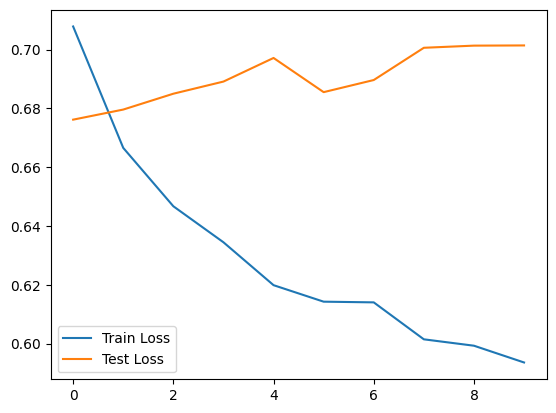

In [39]:
trained_model = train(1, .0001, 32, 10, display=True, early_stopping=False)

## Model Evaluation

Optimal Threshold: 0.4692900776863098
ROC: 0.4922019660262229
Accuracy: 0.44936993699369937
Sensitivity: 0.7684283727399166
Specificity: 0.2967398536260812
PPV: 0.3432743087915502
NPV: 0.7281632653061224


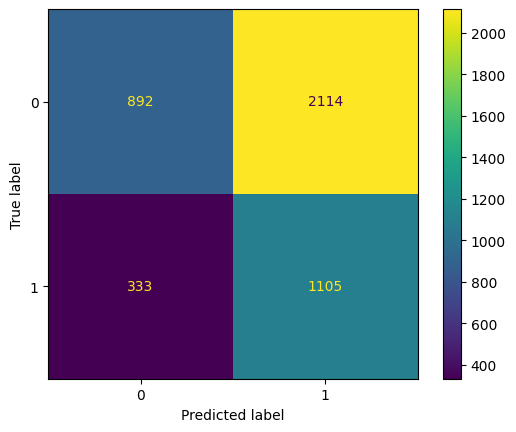

In [40]:
eval_model(trained_model, test_dataset)

## Evaluation Set

In [41]:
eval_dataset = load_dataset('data/meta/eval.csv', files_to_load='all')

Optimal Threshold: 0.4697871208190918
ROC: 0.7534049385549433
Accuracy: 0.7252521798598051
Sensitivity: 0.8213105726872246
Specificity: 0.5678845286423094
PPV: 0.7569144887084497
NPV: 0.659853249475891


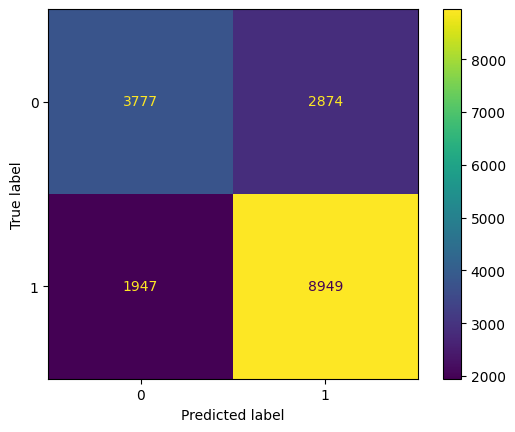

In [42]:
eval_model(trained_model, eval_dataset)

In [43]:
# save model
torch.save(trained_model.state_dict(), '1.pth')